In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid
import networkx as nx 

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/figures/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


## Load data

In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id", "comments_n"]].dropna()
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")
comment_public = comment_public[comment_public["author_name"]!=""]

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

## Load channel labels

In [3]:
channel_labels_all = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_all

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_all[channel_labels_all[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    # print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = {}
        CHANNEL_LABEL_MAP[this_ch]["leaning"] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"]["leaning"] = 1
len(CHANNEL_LABEL_MAP)

564

In [4]:
these_channels = CHANNEL_LABEL_MAP.keys()
pol_view = view_all[view_all["channel_id"].isin(these_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(these_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(these_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(these_channels)].copy()

### Build channel networks --> output node/edge tables are read in Gephi for visualizations (Figure 5)

In [5]:
from src.utils.network_builder import build_projection, read_network
import os

# make output directories
os.makedirs(OUTPATH + "/networks/", exist_ok=True)
os.makedirs(OUTPATH + "/networks/view/", exist_ok=True)
os.makedirs(OUTPATH + "/networks/subscribe/", exist_ok=True)
os.makedirs(OUTPATH + "/networks/comment/", exist_ok=True)

In [6]:
# viewing network -- uncomment this if we want to generate the network file
# n,e = build_projection(
#     df = pol_view, 
#     node_col = "channel_id",
#     feature_col = "respondent_id",
#     density_thres = 0, # for visualization, I will use the density 0.02
#     node_label_map = CHANNEL_LABEL_MAP,
#     node_labels = ["leaning"],
#     print_info = True,
#     save_num_idx = True,
#     save_fpath = OUTPATH + "/networks/view/")

# # density 0.02
# of nodes: 545
# of edges: 5931

In [7]:
# subscribing network -- uncomment this if we want to generate the network file
n,e = build_projection(
    df = pol_subscribe, 
    node_col = "channel_id",
    feature_col = "respondent_id",
    density_thres = 0, # for visualization, I will use the density 0.05
    node_label_map = CHANNEL_LABEL_MAP,
    node_labels = ["leaning"],
    print_info = True,
    save_num_idx = True,
    save_fpath = OUTPATH + "/networks/subscribe/")

# # density 0.05
# # of nodes: 210
# # of edges: 2195

# of nodes: 210
# of edges: 21945


In [8]:
# commenting network -- uncomment this if we want to generate the network file
n,e = build_projection(
    df = pol_comment, 
    node_col = "channel_id",
    feature_col = "respondent_id",
    density_thres = 0, # for visualization, I will use the density 0.1
    node_label_map = CHANNEL_LABEL_MAP,
    node_labels = ["leaning"],
    print_info = True,
    save_num_idx = True,
    save_fpath = OUTPATH + "/networks/comment/")


# # density 0.1
# # of nodes: 108
# # of edges: 1158

# of nodes: 108
# of edges: 5778


## Compute network-level statistics

In [9]:
def get_node_level_EI(g):
    
    node_attrs = nx.get_node_attributes(g, "leaning")
    node_strgs = nx.degree(g, weight="weight")
    edge_attrs = nx.get_edge_attributes(g, "weight")

    ei_df = pd.DataFrame()
    eis = []
    leanings = []
    strengths = []
    for n in g.nodes():
        n_attr = node_attrs[n]
        n_strg = node_strgs[n]
        neighbors = nx.neighbors(g, n)
        if n_strg > 0:
            internal = 0
            external = 0
            for nei in neighbors:
                try:
                    w = edge_attrs[nei, n]
                except:
                    w = edge_attrs[n, nei]
                if node_attrs[nei] == n_attr:
                    internal += w 
                else:
                    external += w
            ei = (external - internal) / (external + internal)

            eis.append(ei)
            leanings.append(n_attr)
            strengths.append(n_strg)
    
    ei_df["rate"] = eis
    ei_df["leaning"] = leanings
    ei_df["strength"] = strengths
    return ei_df

In [10]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

def compute_assortativity(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    x = []
    y = []
    w = []
    for n1,n2 in g.edges():
        x.append(node_attrs[n1])
        y.append(node_attrs[n2])
        w.append(edge_wghts[(n1, n2)])
    c = corr(np.array(x), np.array(y), np.array(w))
    return c

def node_counter(g):
    node_attrs = nx.get_node_attributes(g, "leaning")
    counter = {
        1:0,
        0:0,
        -1:0
    }
    for _,a in node_attrs.items():
        counter[a] += 1
    return counter

def edge_type_counter(g, weighted=False):
    counter = {
        (1,1):0,
        (0,0):0,
        (-1,-1):0,
        (1,0):0,
        (1,-1):0,
        (0,-1):0,
    }
    node_attrs = nx.get_node_attributes(g, "leaning")
    edge_wghts = nx.get_edge_attributes(g, "weight")
    for n1,n2 in g.edges():
        a1 = node_attrs[n1]
        a2 = node_attrs[n2]
        w = edge_wghts[(n1, n2)]
        if weighted:
            try:
                counter[(a1,a2)] += w
            except:
                counter[(a2,a1)] += w
        else:
            try:
                counter[(a1,a2)] += 1
            except:
                counter[(a2,a1)] += 1
    return counter

### Table 5

Assortativity scores and average EI index for channel networks based on different
forms of engagement.

In [11]:
engage_type = ["view", "subscribe", "comment"]
rate_data = {}
for i,this_folder in enumerate(engage_type):
    try:
        node_df = pd.read_csv(OUTPATH + f"networks/{this_folder}/projnet_channel_id_respondent_id_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"networks/{this_folder}/projnet_channel_id_respondent_id_density0_EDGE.csv")
    except:
        node_df = pd.read_csv(OUTPATH + f"networks/{this_folder}/projnet_channel_id_author_name_density0_NODE.csv")
        edge_df = pd.read_csv(OUTPATH + f"networks/{this_folder}/projnet_channel_id_author_name_density0_EDGE.csv")
    g = read_network(node_df, edge_df, add_node_attrs=True, add_edge_attrs=True)
    rates_df = get_node_level_EI(g)
    rate_data[this_folder] = rates_df
    c = compute_assortativity(g)
    print(this_folder)
    print("assortativity score =", c, "'")
    print("average EI =", rates_df["rate"].mean())

Graph with 545 nodes and 148240 edges
view
assortativity score = 0.08331202091849184 '
average EI = 0.19086906727012487
Graph with 210 nodes and 21945 edges
subscribe
assortativity score = 0.12887254304725188 '
average EI = 0.0801274313037519
Graph with 108 nodes and 5778 edges
comment
assortativity score = 0.31535726022015675 '
average EI = -0.029814493969159875


### Figure 6

Node-level EI homophily indices across channel networks based on different
forms of engagement. The upper figure shows the overall distribution; the bottom figure
breaks down by channel leanings and shows the group-wise variation.

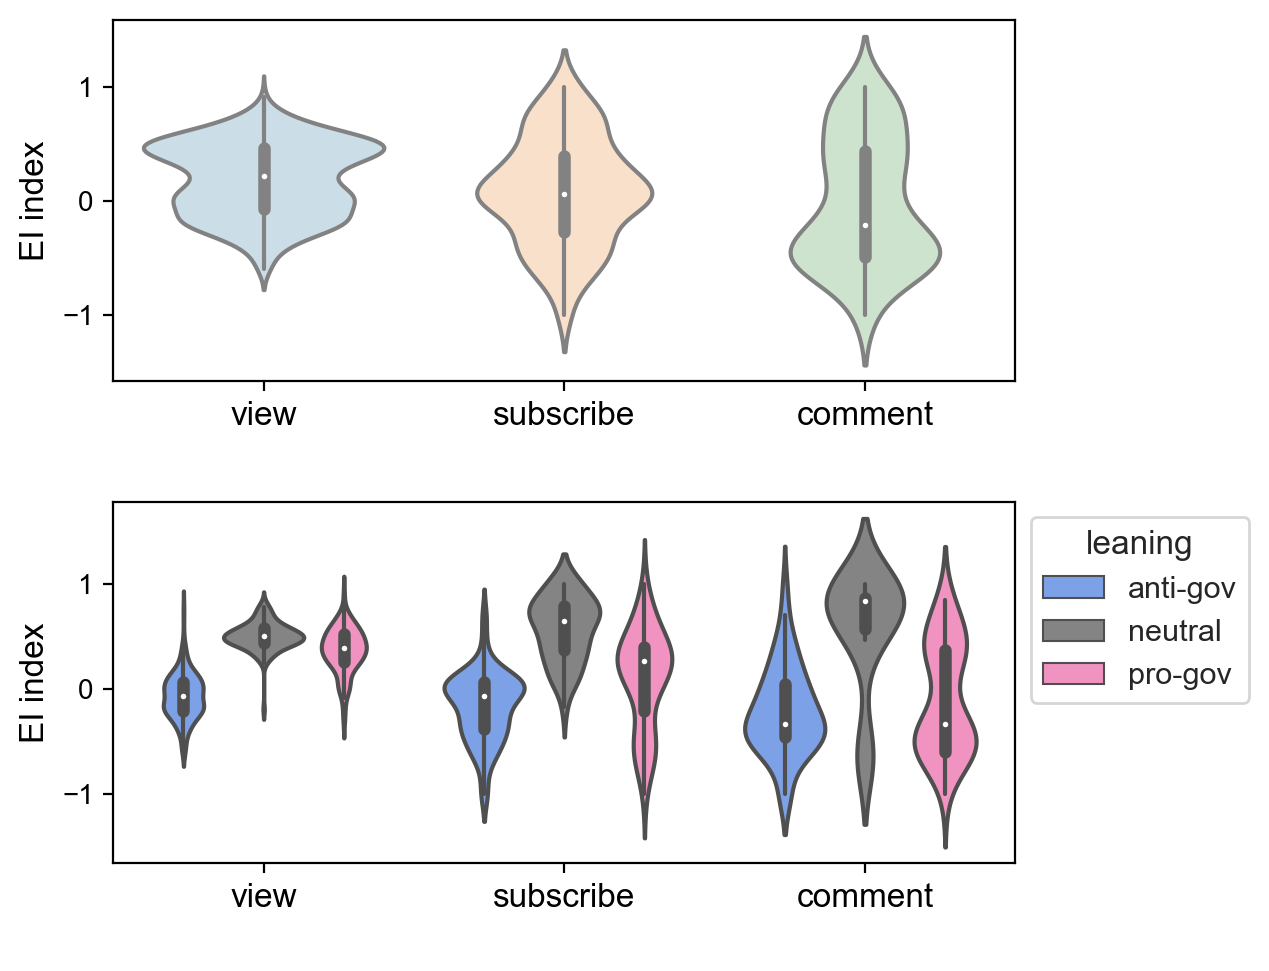

In [12]:
import seaborn as sns
from matplotlib.colors import to_rgba

engage_type = ["view", "subscribe", "comment"]
leaning_map = {-1:"anti-gov", 0:"neutral", 1:"pro-gov"}
sns_data = pd.DataFrame()
for this_folder in engage_type:
    subdf = rate_data[this_folder]
    subdf["engage"] = this_folder
    sns_data = pd.concat([sns_data, subdf])
sns_data["leaning"] = sns_data["leaning"].map(lambda x: leaning_map[x])

# sort the data
sort_dict1 = {"view":0, "subscribe":1, "comment":2, "comment-public":3}
sort_dict2 = {"anti-gov":0, "neutral":1, "pro-gov":2}
sns_data = sns_data.sort_values(by=["leaning"], key=lambda x: x.map(sort_dict2))
sns_data = sns_data.sort_values(by=["engage"], key=lambda x: x.map(sort_dict1))

colors1 = ["#C6DEEC", "#FFDFC3", "#CAE7C9", "#2BA02C"]
colors2 = ["#6B9CF7", "#848484", "#FF84C1"]

fig,ax = plt.subplots(figsize=(6.5,5), nrows=2)
sns.set(style="whitegrid")
sns.violinplot(x="engage", y="rate", data = sns_data, palette=colors1, ax=ax[0])
# sns.boxplot(x="engage", y="rate", data=sns_data, palette=colors1, ax=ax[0])
vp = sns.violinplot(x="engage", y="rate", data = sns_data, hue="leaning", palette=colors2, ax=ax[1], alpha=.4)
    
for i in [0,1]:
    ax[i].set_xlabel(" ")
    ax[i].set_xticks(range(3), engage_type, fontsize=12)
    ax[i].set_ylabel("EI index", fontsize=12)
    # ax[i].set_ylim(-0.25, 1.25)
    # ax[i].set_ylim(-1,1)
sns.move_legend(ax[1], "upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig(OUTPATH + "ei-homophily-channel-level-3grp.pdf", dpi=300, bbox_inches="tight")

## KS-test to compare the difference of node-level EI index - Table 8

In [13]:
COMPARE_PARIS = [
    ("view", "comment"),
    ("subscribe", "comment"),
]

In [14]:
# compare the distribution 
from scipy.stats import entropy, ks_2samp, mannwhitneyu
from src.utils.functions import compare_distribution_with_sig, compare_distribution_with_sig_weighted

for g1, g2 in COMPARE_PARIS:
    subdf1 = sns_data[sns_data["engage"]==g1]
    subdf2 = sns_data[sns_data["engage"]==g2]
    p1, p2 = compare_distribution_with_sig(
        sample1=subdf1["rate"].tolist(), 
        sample2=subdf2["rate"].tolist(), 
        bruns=1000,
        test_func=ks_2samp, 
        sample_size=min(len(subdf1), len(subdf2)))
    print("p1 =", p1, "\tp2 =", p2, "\n")   


N1 = 105 	N2 = 105
p1 = 0.0 	p2 = 0.0 

N1 = 105 	N2 = 105
p1 = 0.0 	p2 = 0.0 

